In [ ]:
import cv2
import dlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import os
import glob as gb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import time
import random
import torchvision.transforms as transforms
import albumentations as A
import torchvision.models as models

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [ ]:
dataset_url="https://www.kaggle.com/datasets/sorokin/faceforensics"

In [ ]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: karthickkrishna1
Your Kaggle Key: ··········


100%|██████████| 8.40G/8.40G [01:10<00:00, 128MB/s]


In [ ]:
from google.colab.patches import cv2_imshow
import os

In [ ]:
detector = dlib.get_frontal_face_detector()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
eff_b4 = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.DEFAULT).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

In [ ]:
for param in eff_b4.parameters():
  param.requires_grad = False

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # x: (n, 28, 28), h0: (2, n, 128)

        # Forward propagate RNN

        out, _ = self.lstm(x, (h0,c0))

        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)

        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)

        # out = self.fc(out)
        # out: (n, 10)
        return out

In [ ]:
lstm = LSTM(input_size=1792, hidden_size=128, num_layers=2)

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.lstm = lstm
    self.fc = nn.Linear(self.lstm.hidden_size, 512)
    self.classifier = nn.Linear(512,1)

  def forward(self,x):
    out = self.lstm(x)
    out = self.classifier(self.fc(out))
    return out

In [ ]:
model = Model()

In [ ]:
fake = '/content/faceforensics/manipulated_sequences/Deepfakes/c23/videos/'
real = '/content/faceforensics/original_sequences/youtube/c23/videos/'

In [ ]:
def extract_seq(vid_path, seq_length):
  vidcap = cv2.VideoCapture(vid_path)
  success = True
  faces = []
  while len(faces)<seq_length:
    success,image = vidcap.read()
    face_frame = detector(image)
    if face_frame:
      for counter,face in enumerate(face_frame):
              x1, y1 = face.left(), face.top()
              x2, y2 = face.right(), face.bottom()
              imgCrop = image[y1:y2, x1:x2]
              try:
                face = cv2.resize(imgCrop, (224, 224))
                enc = eff_b4(face)
                faces.append(enc)
              except:
                continue
  return faces


In [ ]:
fake_files = gb.glob(pathname= fake+'/*.mp4')
fake_train = random.sample(fake_files, 700)
fake_no_train = [i for i in fake_files if i not in fake_train]
fake_test = random.sample(fake_no_train, 150)
fake_val = [i for i in fake_no_train if i not in fake_test]

In [ ]:
real_files = gb.glob(pathname= real+'/*.mp4')
real_train = random.sample(real_files, 700)
real_no_train = [i for i in real_files if i not in real_train]
real_test = random.sample(real_no_train, 150)
real_val = [i for i in real_no_train if i not in real_test]

In [ ]:
train = real_train + fake_train
test = real_test + fake_test
val = real_val +fake_val
#create label array
train_label = [0 for i in range(700)] + [1 for i in range(700)]
test_label = [0 for i in range(150)] + [1 for i in range(150)]
val_label = [0 for i in range(150)] + [1 for i in range(150)]

In [ ]:
from torch.utils.data import Dataset

class customDataset(Dataset):
    def __init__(self, files, seq_length, labels, transform = None):
        sequences = []
        c = 0
        for i in files:
          seq = extract_seq(i, seq_length)
          enc = []
          for i in seq:
            enc.append(eff_b4(i))
          sequences.append(enc)
          c+=1
          print(c*100/len(files))
        self.sequences = sequences
        self.labels = torch.FloatTensor(labels)
        self.transform = transform

    def __getitem__(self, index):
        sequence = self.sequences[index]
        label = self.labels[index]
        if self.transform:
          sequence = self.transform(sequence)
        return sequence, label

    def __len__(self):
        return len(self.sequences)

In [ ]:
enc = extract_seq('/content/faceforensics/manipulated_sequences/Deepfakes/c23/videos/000_003.mp4', 3)

TypeError: ignored

In [ ]:
train_data = customDataset(train, 3, train_label)

RuntimeError: ignored

In [ ]:
import torch.optim as optim

epochs = 20
lr = 0.001
optimizer = optim.Adam
criterion = torch.nn.functional.binary_cross_entropy_with_logits


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def accuracy(y_pred, y):
    predicted = torch.max(y_pred.data)
    predicted=torch.round(y_pred)
    total = y.size(0)
    correct = (predicted == y).sum().item()
    return correct/total

def train(model, dataset, opt_fn, criterion,epoch,learning_rate):

    optimizer=opt_fn(model.parameters(),learning_rate)
    model.train()
    train_loss=[]
    train_acc=[]
    for batch_idx,(data,target) in enumerate(dataset):
        print(len(data))
        data, target = torch.tensor(data).to(device), target.to(device)
        optimizer.zero_grad()
        output=model(data)
        output=torch.squeeze(output,1)
        loss=criterion(output,target)
        bceloss=torch.nn.BCELoss()
        logloss=bceloss(output,target)
        loss.backward()
        optimizer.step()
        acc = accuracy(output, target)
        train_acc.append(acc)
        train_loss.append(loss.item())
        print('\repoch:{}({:.0f}%)\tloss:{:.3f}\ttrain_accuracy:{:.2f}%'.format(epoch+1,100*batch_idx/len(dataset),
        np.mean(train_loss),100*np.mean(train_acc)),end='')

def eval(model, dataset, criterion):

    model.eval()
    val_acc=[]
    for batch_idx,(data,target) in enumerate(dataset):
        data, target = data.cuda(), target.cuda()
        output=model.forward2(data)
        output=output.squeeze(1)
        acc = accuracy(output, target)
        val_acc.append(acc)
    print('val_accuracy:{:.2f}%'.format(100*np.mean(val_acc)))
    return np.mean(val_acc)

In [ ]:
data_loader = DataLoader(train_data, batch_size=10)

In [ ]:
for epoch in range(epochs):
      start_time = time.monotonic()
      train(model, data_loader, optimizer, criterion,epoch,lr)
      #eval_accuracy = eval(model, test_loader, criterion)
      end_time = time.monotonic()
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

      print("TIME TAKEN FOR THE EPOCH: {} mins and {} seconds\n".format(epoch_mins, epoch_secs))
print("OVERALL TRAINING COMPLETE")

# Colour Histogram

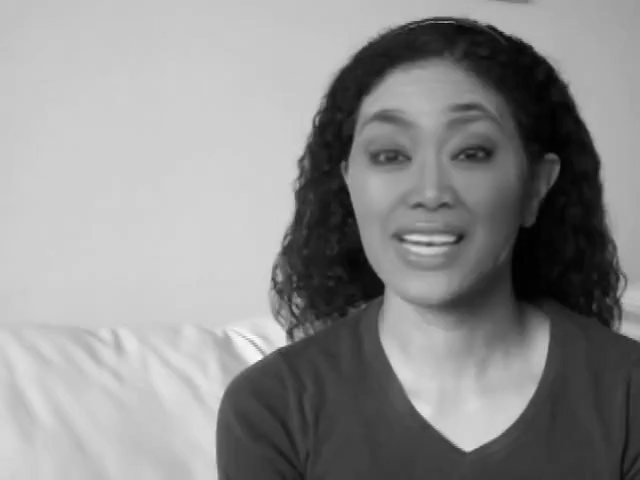

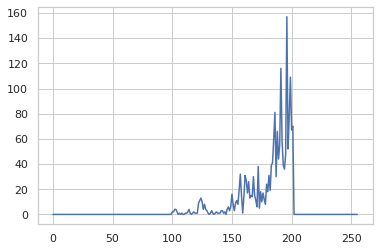

In [ ]:
vid = cv2.VideoCapture('/content/faceforensics/manipulated_sequences/Deepfakes/c23/videos/042_084.mp4')
_, img = vid.read()
grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
dst = cv2.calcHist(img, [0], None, [256], [0,256])
# print(dst)
cv2_imshow(grayscale)
# plt.hist(img.ravel(),256,[0,256])
# plt.title('Histogram for gray scale image')
plt.plot(dst)
plt.show()


In [ ]:
def min_frames(path):
  files = gb.glob(pathname= str(path + '/*.mp4'))
  frames = []
  for file in files:
    vidcap = cv2.VideoCapture(file)
    length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames.append(length)
  return min(frames)

In [ ]:
min_frames("/content/faceforensics/manipulated_sequences/Deepfakes/c23/videos")

287

In [ ]:
min_frames("/content/faceforensics/original_sequences/youtube/c23/videos")

287

In [ ]:
def extract_hist(path, n):
  vid_count = 0
  files = gb.glob(pathname= str(path + '/*.mp4'))
  for file in files:
    if c==n:
      break